## Prepare Data

In [ ]:
"""
数据准备脚本
功能：
1. 从YOLO格式数据集读取并划分训练集和验证集
2. 为目标检测准备数据（所有类别统一为"fly"）
3. 为分类准备裁剪后的图像数据集（Long/Short/Ambiguous）
"""

import shutil
from pathlib import Path
import random
from PIL import Image
from tqdm import tqdm


class DataPreparation:
    def __init__(self, yolo_data_root, output_root, train_ratio=0.8, exclude_ambiguous=True):
        """
        Args:
            yolo_data_root: YOLO格式数据根目录（包含images/和labels/子目录）
            output_root: 输出目录
            train_ratio: 训练集比例
            exclude_ambiguous: 是否排除Ambiguous类别
        """
        self.yolo_data_root = Path(yolo_data_root)
        self.images_dir = self.yolo_data_root / 'images'
        self.labels_dir = self.yolo_data_root / 'labels'
        self.classes_file = self.yolo_data_root / 'classes.txt'
        self.output_root = Path(output_root)
        self.train_ratio = train_ratio
        self.exclude_ambiguous = exclude_ambiguous

        # 读取类别
        with open(self.classes_file, 'r', encoding='utf-8') as f:
            self.classes = [line.strip() for line in f if line.strip()]

        print(f"类别: {self.classes}")

        # 获取所有图像文件
        self.image_files = sorted(list(self.images_dir.glob('*.jpg')) + list(self.images_dir.glob('*.png')))

        # 过滤出有对应标注文件的图像
        self.valid_images = []
        for img_path in self.image_files:
            label_path = self.labels_dir / (img_path.stem + '.txt')
            if label_path.exists():
                self.valid_images.append(img_path)

        print(f"加载数据集: {len(self.valid_images)} 张有效图片（共 {len(self.image_files)} 张）")

    def parse_yolo_label(self, label_path, img_width, img_height):
        """解析YOLO格式标注文件

        Args:
            label_path: 标注文件路径
            img_width: 图像宽度
            img_height: 图像高度

        Returns:
            boxes: [(class_id, x1, y1, x2, y2), ...]
        """
        boxes = []

        if not label_path.exists():
            return boxes

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # 转换为绝对坐标
                x1 = (x_center - width / 2) * img_width
                y1 = (y_center - height / 2) * img_height
                x2 = (x_center + width / 2) * img_width
                y2 = (y_center + height / 2) * img_height

                boxes.append((class_id, x1, y1, x2, y2))

        return boxes

    def prepare_detection_data(self):
        """准备目标检测数据（YOLO格式，所有类别统一为fly）"""
        print("\n=== 准备目标检测数据 ===")

        # 创建输出目录
        detection_root = self.output_root / "detection"
        for split in ['train', 'val']:
            (detection_root / split / 'images').mkdir(parents=True, exist_ok=True)
            (detection_root / split / 'labels').mkdir(parents=True, exist_ok=True)

        # 划分训练集和验证集
        images = self.valid_images.copy()
        random.shuffle(images)
        train_size = int(len(images) * self.train_ratio)
        train_images = images[:train_size]
        val_images = images[train_size:]

        print(f"训练集: {len(train_images)} 张, 验证集: {len(val_images)} 张")

        # 处理训练集和验证集
        for split, img_list in [('train', train_images), ('val', val_images)]:
            print(f"\n处理{split}集...")
            for img_path in tqdm(img_list):
                # 复制图片
                output_img_path = detection_root / split / 'images' / img_path.name
                shutil.copy(img_path, output_img_path)

                # 读取并转换标注（所有类别统一为0）
                label_path = self.labels_dir / (img_path.stem + '.txt')
                output_label_path = detection_root / split / 'labels' / (img_path.stem + '.txt')

                with open(label_path, 'r') as f_in, open(output_label_path, 'w') as f_out:
                    for line in f_in:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            # 将所有类别改为0（统一为fly）
                            f_out.write(f"0 {' '.join(parts[1:])}\n")

        # 生成data.yaml配置文件
        yaml_content = f"""path: {detection_root.absolute()}
train: train/images
val: val/images

nc: 1
names: ['fly']
"""
        with open(detection_root / 'data.yaml', 'w') as f:
            f.write(yaml_content)

        print(f"\n✅ 目标检测数据准备完成！保存在: {detection_root}")
        return detection_root / 'data.yaml'

    def prepare_classification_data(self):
        """准备分类数据（裁剪后的图像，按类别分类）"""
        print("\n=== 准备分类数据 ===")

        # 创建输出目录
        classification_root = self.output_root / "classification"

        # 确定要处理的类别
        if self.exclude_ambiguous:
            target_classes = [c for c in self.classes if c != 'Ambiguous']
        else:
            target_classes = self.classes

        print(f"处理类别: {target_classes}")

        for split in ['train', 'val']:
            for category in target_classes:
                (classification_root / split / category).mkdir(parents=True, exist_ok=True)

        # 划分训练集和验证集（使用相同的划分）
        images = self.valid_images.copy()
        random.shuffle(images)
        train_size = int(len(images) * self.train_ratio)
        train_images = set(images[:train_size])

        # 处理所有图像
        print("裁剪并保存图像...")
        crop_counts = {'train': {}, 'val': {}}

        for img_path in tqdm(self.valid_images):
            # 确定是训练集还是验证集
            split = 'train' if img_path in train_images else 'val'

            # 读取图像
            try:
                img = Image.open(img_path).convert('RGB')
            except Exception as e:
                print(f"无法打开图像 {img_path}: {e}")
                continue

            # 读取标注
            label_path = self.labels_dir / (img_path.stem + '.txt')
            boxes = self.parse_yolo_label(label_path, img.width, img.height)

            # 裁剪每个标注框
            for idx, (class_id, x1, y1, x2, y2) in enumerate(boxes):
                category_name = self.classes[class_id]

                # 如果排除Ambiguous类别
                if self.exclude_ambiguous and category_name == 'Ambiguous':
                    continue

                # 确保边界在图像内
                x1 = max(0, int(x1))
                y1 = max(0, int(y1))
                x2 = min(img.width, int(x2))
                y2 = min(img.height, int(y2))

                if x2 <= x1 or y2 <= y1:
                    continue

                # 裁剪
                cropped = img.crop((x1, y1, x2, y2))

                # 保存
                if category_name not in crop_counts[split]:
                    crop_counts[split][category_name] = 0
                crop_counts[split][category_name] += 1

                crop_filename = f"{img_path.stem}_{idx}_{category_name}.jpg"
                output_path = classification_root / split / category_name / crop_filename
                cropped.save(output_path, quality=95)

        # 打印统计信息
        print(f"\n✅ 分类数据准备完成！保存在: {classification_root}")
        print("\n数据集统计:")
        for split in ['train', 'val']:
            print(f"\n{split}集:")
            total = sum(crop_counts[split].values())
            for category, count in sorted(crop_counts[split].items()):
                percentage = 100 * count / total if total > 0 else 0
                print(f"  {category}: {count} ({percentage:.1f}%)")

        return classification_root


def main():
    # 设置随机种子
    random.seed(42)

    # 配置路径
    yolo_data_root = "data_yolo"  # YOLO格式数据目录
    output_root = "processed_data"

    # 创建数据准备对象
    data_prep = DataPreparation(
        yolo_data_root=yolo_data_root,
        output_root=output_root,
        train_ratio=0.8,
        exclude_ambiguous=True  # 排除Ambiguous类别
    )

    # 准备目标检测数据
    yaml_path = data_prep.prepare_detection_data()

    # 准备分类数据
    classification_root = data_prep.prepare_classification_data()

    print("\n" + "="*60)
    print("✅ 数据准备完成！")
    print(f"检测数据配置: {yaml_path}")
    print(f"分类数据目录: {classification_root}")
    print("="*60)


if __name__ == "__main__":
    main()


## Prepare files for Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
import zipfile
from pathlib import Path

# 请将此路径替换为你 Google Drive 中 zip 文件的实际路径
drive_zip_path = '/content/drive/MyDrive/genetics-project/processed_data.zip' # 例如: '/content/drive/MyDrive/data_yolo.zip'
local_zip_path = Path('./dataset.zip')

if Path(drive_zip_path).exists():
    print(f"正在从 Google Drive 复制 {drive_zip_path} 到当前目录...")
    shutil.copy(drive_zip_path, local_zip_path)
    print("复制完成。")

    if local_zip_path.exists():
        print(f"正在解压 {local_zip_path}...")
        with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')
        print("解压完成。")
        # 解压后删除 zip 文件以节省空间
        local_zip_path.unlink()
        print(f"已删除 {local_zip_path}。")
    else:
        print(f"错误: 无法找到复制后的文件 {local_zip_path}。")
else:
    print(f"错误: 未找到 Google Drive 中的 zip 文件: {drive_zip_path}。请检查路径是否正确。")

正在从 Google Drive 复制 /content/drive/MyDrive/genetics-project/processed_data.zip 到当前目录...
复制完成。
正在解压 dataset.zip...
解压完成。
已删除 dataset.zip。


## train_detection

In [6]:
"""
果蝇目标检测训练脚本（YOLOv8）
使用YOLOv8进行果蝇检测（不区分类别）
"""

import os
from pathlib import Path
from ultralytics import YOLO
import torch


class FlyDetectionTrainer:
    def __init__(self, data_yaml, model_name='yolov8n.pt', epochs=100, img_size=640, batch_size=16):
        """
        Args:
            data_yaml: 数据配置文件路径
            model_name: 预训练模型名称
            epochs: 训练轮数
            img_size: 图像尺寸
            batch_size: 批次大小
        """
        self.data_yaml = data_yaml
        self.model_name = model_name
        self.epochs = epochs
        self.img_size = img_size
        self.batch_size = batch_size

    def train(self, project='runs/detect', name='fly_detector'):
        """训练目标检测模型"""
        print("=== 开始训练果蝇检测模型 ===")
        print(f"模型: {self.model_name}")
        print(f"数据配置: {self.data_yaml}")
        print(f"训练轮数: {self.epochs}")
        print(f"图像尺寸: {self.img_size}")
        print(f"批次大小: {self.batch_size}")
        print(f"设备: {'cuda' if torch.cuda.is_available() else 'cpu'}")

        # 加载预训练模型
        model = YOLO(self.model_name)

        # 训练参数
        results = model.train(
            data=self.data_yaml,
            epochs=self.epochs,
            imgsz=self.img_size,
            batch=self.batch_size,
            project=project,
            name=name,
            patience=20,  # 早停耐心值
            save=True,
            save_period=10,  # 每10个epoch保存一次
            # 数据增强
            hsv_h=0.015,
            hsv_s=0.7,
            hsv_v=0.4,
            degrees=10.0,
            translate=0.1,
            scale=0.5,
            shear=0.0,
            perspective=0.0,
            flipud=0.5,
            fliplr=0.5,
            mosaic=1.0,
            mixup=0.1,
            # 优化器
            optimizer='AdamW',
            lr0=0.01,
            lrf=0.01,
            momentum=0.937,
            weight_decay=0.0005,
            warmup_epochs=3,
            warmup_momentum=0.8,
            warmup_bias_lr=0.1,
            # 其他
            cos_lr=True,
            label_smoothing=0.0,
            box=7.5,
            cls=0.5,
            dfl=1.5,
            plots=True,
            verbose=True,
        )

        print("\n✅ 训练完成！")
        print(f"最佳模型保存在: {Path(project) / name / 'weights' / 'best.pt'}")

        return results

    def validate(self, model_path, project='runs/detect', name='val'):
        """验证模型"""
        print("\n=== 验证模型 ===")
        model = YOLO(model_path)

        results = model.val(
            data=self.data_yaml,
            imgsz=self.img_size,
            batch=self.batch_size,
            project=project,
            name=name,
            plots=True,
        )

        print("\n验证结果:")
        print(f"mAP50: {results.box.map50:.4f}")
        print(f"mAP50-95: {results.box.map:.4f}")
        print(f"Precision: {results.box.mp:.4f}")
        print(f"Recall: {results.box.mr:.4f}")

        return results


def main():
    # 配置参数
    data_yaml = "datasets/detection/data.yaml"

    # 创建训练器
    trainer = FlyDetectionTrainer(
        data_yaml=data_yaml,
        model_name='yolo11n.pt',  # 可选: yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
        epochs=100,
        img_size=640,
        batch_size=16,
    )

    # 训练模型
    results = trainer.train(project='runs/detect', name='fly_detector')

    # 验证最佳模型
    best_model_path = 'runs/detect/fly_detector/weights/best.pt'
    if Path(best_model_path).exists():
        trainer.validate(best_model_path, project='runs/detect', name='val_best')


if __name__ == "__main__":
    main()


=== 开始训练果蝇检测模型 ===
模型: yolov8n.pt
数据配置: datasets/detection/data.yaml
训练轮数: 100
图像尺寸: 640
批次大小: 16
设备: cuda
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.238 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=datasets/detection/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, mome

## train_classification

train集: 562 个样本
val集: 138 个样本


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


模型: resnet50, 设备: cuda, 类别数: 2

=== 开始训练 ===


Epoch 1/50: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s, loss=0.5584, acc=71.17%]


Epoch 1/50: Train Loss: 0.6986, Train Acc: 71.17%, Val Loss: 55.8572, Val Acc: 21.01%, LR: 0.000999
✅ 保存最佳模型 (Val Acc: 21.01%)


Epoch 2/50: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s, loss=0.2452, acc=76.69%]


Epoch 2/50: Train Loss: 0.5251, Train Acc: 76.69%, Val Loss: 0.6792, Val Acc: 77.54%, LR: 0.000996
✅ 保存最佳模型 (Val Acc: 77.54%)


Epoch 3/50: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s, loss=0.3319, acc=76.51%]


Epoch 3/50: Train Loss: 0.5201, Train Acc: 76.51%, Val Loss: 0.5875, Val Acc: 78.26%, LR: 0.000991
✅ 保存最佳模型 (Val Acc: 78.26%)


Epoch 4/50: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s, loss=0.5150, acc=75.62%]


Epoch 4/50: Train Loss: 0.5638, Train Acc: 75.62%, Val Loss: 0.6954, Val Acc: 78.26%, LR: 0.000984


Epoch 5/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.8884, acc=76.69%]


Epoch 5/50: Train Loss: 0.5525, Train Acc: 76.69%, Val Loss: 1.1810, Val Acc: 78.26%, LR: 0.000976


Epoch 6/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.4512, acc=76.51%]


Epoch 6/50: Train Loss: 0.5344, Train Acc: 76.51%, Val Loss: 0.5908, Val Acc: 79.71%, LR: 0.000965
✅ 保存最佳模型 (Val Acc: 79.71%)


Epoch 7/50: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s, loss=0.8155, acc=77.76%]


Epoch 7/50: Train Loss: 0.5458, Train Acc: 77.76%, Val Loss: 0.6766, Val Acc: 76.81%, LR: 0.000952


Epoch 8/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.3345, acc=77.40%]


Epoch 8/50: Train Loss: 0.4972, Train Acc: 77.40%, Val Loss: 0.5356, Val Acc: 79.71%, LR: 0.000938


Epoch 9/50: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s, loss=0.6611, acc=78.29%]


Epoch 9/50: Train Loss: 0.5044, Train Acc: 78.29%, Val Loss: 0.4916, Val Acc: 83.33%, LR: 0.000922
✅ 保存最佳模型 (Val Acc: 83.33%)


Epoch 10/50: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s, loss=0.5364, acc=78.65%]


Epoch 10/50: Train Loss: 0.4587, Train Acc: 78.65%, Val Loss: 0.6571, Val Acc: 78.99%, LR: 0.000905


Epoch 11/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.6756, acc=80.78%]


Epoch 11/50: Train Loss: 0.4533, Train Acc: 80.78%, Val Loss: 0.8677, Val Acc: 78.26%, LR: 0.000885


Epoch 12/50: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s, loss=0.3360, acc=79.00%]


Epoch 12/50: Train Loss: 0.4556, Train Acc: 79.00%, Val Loss: 0.9165, Val Acc: 63.04%, LR: 0.000864


Epoch 13/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.5198, acc=77.58%]


Epoch 13/50: Train Loss: 0.4587, Train Acc: 77.58%, Val Loss: 0.4902, Val Acc: 84.06%, LR: 0.000842
✅ 保存最佳模型 (Val Acc: 84.06%)


Epoch 14/50: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s, loss=0.3460, acc=81.14%]


Epoch 14/50: Train Loss: 0.4346, Train Acc: 81.14%, Val Loss: 0.9951, Val Acc: 80.43%, LR: 0.000819


Epoch 15/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.8952, acc=81.14%]


Epoch 15/50: Train Loss: 0.4311, Train Acc: 81.14%, Val Loss: 0.4776, Val Acc: 81.88%, LR: 0.000794


Epoch 16/50: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s, loss=0.2059, acc=80.25%]


Epoch 16/50: Train Loss: 0.3878, Train Acc: 80.25%, Val Loss: 0.5142, Val Acc: 77.54%, LR: 0.000768


Epoch 17/50: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s, loss=0.3233, acc=81.67%]


Epoch 17/50: Train Loss: 0.4211, Train Acc: 81.67%, Val Loss: 0.5279, Val Acc: 82.61%, LR: 0.000741


Epoch 18/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.3720, acc=83.27%]


Epoch 18/50: Train Loss: 0.4100, Train Acc: 83.27%, Val Loss: 0.6643, Val Acc: 80.43%, LR: 0.000713


Epoch 19/50: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s, loss=0.3930, acc=83.10%]


Epoch 19/50: Train Loss: 0.4045, Train Acc: 83.10%, Val Loss: 0.4685, Val Acc: 86.23%, LR: 0.000684
✅ 保存最佳模型 (Val Acc: 86.23%)


Epoch 20/50: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s, loss=0.4327, acc=82.56%]


Epoch 20/50: Train Loss: 0.4000, Train Acc: 82.56%, Val Loss: 0.4344, Val Acc: 86.23%, LR: 0.000655


Epoch 21/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.2088, acc=84.16%]


Epoch 21/50: Train Loss: 0.3787, Train Acc: 84.16%, Val Loss: 0.4266, Val Acc: 84.78%, LR: 0.000624


Epoch 22/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.2565, acc=84.88%]


Epoch 22/50: Train Loss: 0.3477, Train Acc: 84.88%, Val Loss: 0.5251, Val Acc: 84.78%, LR: 0.000594


Epoch 23/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.3593, acc=81.85%]


Epoch 23/50: Train Loss: 0.4079, Train Acc: 81.85%, Val Loss: 0.9620, Val Acc: 61.59%, LR: 0.000563


Epoch 24/50: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s, loss=0.2620, acc=83.45%]


Epoch 24/50: Train Loss: 0.3652, Train Acc: 83.45%, Val Loss: 0.6731, Val Acc: 78.99%, LR: 0.000531


Epoch 25/50: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s, loss=0.1731, acc=86.48%]


Epoch 25/50: Train Loss: 0.3216, Train Acc: 86.48%, Val Loss: 0.3611, Val Acc: 86.96%, LR: 0.000500
✅ 保存最佳模型 (Val Acc: 86.96%)


Epoch 26/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.3137, acc=85.23%]


Epoch 26/50: Train Loss: 0.3571, Train Acc: 85.23%, Val Loss: 0.4268, Val Acc: 84.06%, LR: 0.000469


Epoch 27/50: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s, loss=0.8365, acc=87.37%]


Epoch 27/50: Train Loss: 0.3320, Train Acc: 87.37%, Val Loss: 0.3811, Val Acc: 86.96%, LR: 0.000437


Epoch 28/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.6769, acc=87.90%]


Epoch 28/50: Train Loss: 0.3159, Train Acc: 87.90%, Val Loss: 0.4957, Val Acc: 84.06%, LR: 0.000406


Epoch 29/50: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s, loss=0.2472, acc=87.54%]


Epoch 29/50: Train Loss: 0.2998, Train Acc: 87.54%, Val Loss: 0.4613, Val Acc: 84.78%, LR: 0.000376


Epoch 30/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.3397, acc=87.19%]


Epoch 30/50: Train Loss: 0.3172, Train Acc: 87.19%, Val Loss: 0.3604, Val Acc: 89.13%, LR: 0.000345
✅ 保存最佳模型 (Val Acc: 89.13%)


Epoch 31/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.0971, acc=90.04%]


Epoch 31/50: Train Loss: 0.2694, Train Acc: 90.04%, Val Loss: 0.4993, Val Acc: 86.23%, LR: 0.000316


Epoch 32/50: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s, loss=0.0940, acc=90.04%]


Epoch 32/50: Train Loss: 0.2463, Train Acc: 90.04%, Val Loss: 0.4796, Val Acc: 85.51%, LR: 0.000287


Epoch 33/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.3129, acc=89.68%]


Epoch 33/50: Train Loss: 0.2614, Train Acc: 89.68%, Val Loss: 0.3857, Val Acc: 84.06%, LR: 0.000259


Epoch 34/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.4482, acc=88.97%]


Epoch 34/50: Train Loss: 0.2570, Train Acc: 88.97%, Val Loss: 0.3573, Val Acc: 87.68%, LR: 0.000232


Epoch 35/50: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s, loss=0.1803, acc=93.42%]


Epoch 35/50: Train Loss: 0.2109, Train Acc: 93.42%, Val Loss: 0.3104, Val Acc: 89.86%, LR: 0.000206
✅ 保存最佳模型 (Val Acc: 89.86%)


Epoch 36/50: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s, loss=0.4813, acc=90.75%]


Epoch 36/50: Train Loss: 0.2372, Train Acc: 90.75%, Val Loss: 0.3425, Val Acc: 89.86%, LR: 0.000181


Epoch 37/50: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s, loss=0.1856, acc=91.10%]


Epoch 37/50: Train Loss: 0.2339, Train Acc: 91.10%, Val Loss: 0.3539, Val Acc: 89.13%, LR: 0.000158


Epoch 38/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.7037, acc=91.99%]


Epoch 38/50: Train Loss: 0.2242, Train Acc: 91.99%, Val Loss: 0.3850, Val Acc: 89.13%, LR: 0.000136


Epoch 39/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.1007, acc=92.88%]


Epoch 39/50: Train Loss: 0.1896, Train Acc: 92.88%, Val Loss: 0.3635, Val Acc: 87.68%, LR: 0.000115


Epoch 40/50: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s, loss=0.1478, acc=93.77%]


Epoch 40/50: Train Loss: 0.1694, Train Acc: 93.77%, Val Loss: 0.4256, Val Acc: 86.96%, LR: 0.000095


Epoch 41/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.1347, acc=94.31%]


Epoch 41/50: Train Loss: 0.1613, Train Acc: 94.31%, Val Loss: 0.4453, Val Acc: 86.23%, LR: 0.000078


Epoch 42/50: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s, loss=0.2709, acc=94.84%]


Epoch 42/50: Train Loss: 0.1568, Train Acc: 94.84%, Val Loss: 0.4346, Val Acc: 88.41%, LR: 0.000062


Epoch 43/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.0856, acc=95.73%]


Epoch 43/50: Train Loss: 0.1244, Train Acc: 95.73%, Val Loss: 0.3652, Val Acc: 88.41%, LR: 0.000048


Epoch 44/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.0312, acc=96.26%]


Epoch 44/50: Train Loss: 0.1250, Train Acc: 96.26%, Val Loss: 0.3417, Val Acc: 86.96%, LR: 0.000035


Epoch 45/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.0624, acc=96.09%]


Epoch 45/50: Train Loss: 0.1231, Train Acc: 96.09%, Val Loss: 0.3630, Val Acc: 89.13%, LR: 0.000024


Epoch 46/50: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s, loss=0.0531, acc=95.55%]


Epoch 46/50: Train Loss: 0.1304, Train Acc: 95.55%, Val Loss: 0.3971, Val Acc: 87.68%, LR: 0.000016


Epoch 47/50: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, loss=0.1312, acc=95.55%]


Epoch 47/50: Train Loss: 0.1279, Train Acc: 95.55%, Val Loss: 0.3764, Val Acc: 89.86%, LR: 0.000009


Epoch 48/50: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s, loss=0.0817, acc=95.55%]


Epoch 48/50: Train Loss: 0.1274, Train Acc: 95.55%, Val Loss: 0.3622, Val Acc: 89.86%, LR: 0.000004


Epoch 49/50: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s, loss=0.0713, acc=95.73%]


Epoch 49/50: Train Loss: 0.1271, Train Acc: 95.73%, Val Loss: 0.3578, Val Acc: 89.86%, LR: 0.000001


Epoch 50/50: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, loss=0.2244, acc=95.91%]


Epoch 50/50: Train Loss: 0.1215, Train Acc: 95.91%, Val Loss: 0.3629, Val Acc: 89.86%, LR: 0.000000
训练曲线保存在: runs/classification/training_history.png

✅ 训练完成！最佳验证准确率: 89.86%
模型保存在: runs/classification/best_model.pth

=== 评估模型 ===


评估中: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]



分类报告:
              precision    recall  f1-score   support

        Long       0.91      0.96      0.94       108
       Short       0.83      0.67      0.74        30

    accuracy                           0.90       138
   macro avg       0.87      0.81      0.84       138
weighted avg       0.90      0.90      0.89       138


混淆矩阵保存在: runs/classification/confusion_matrix.png


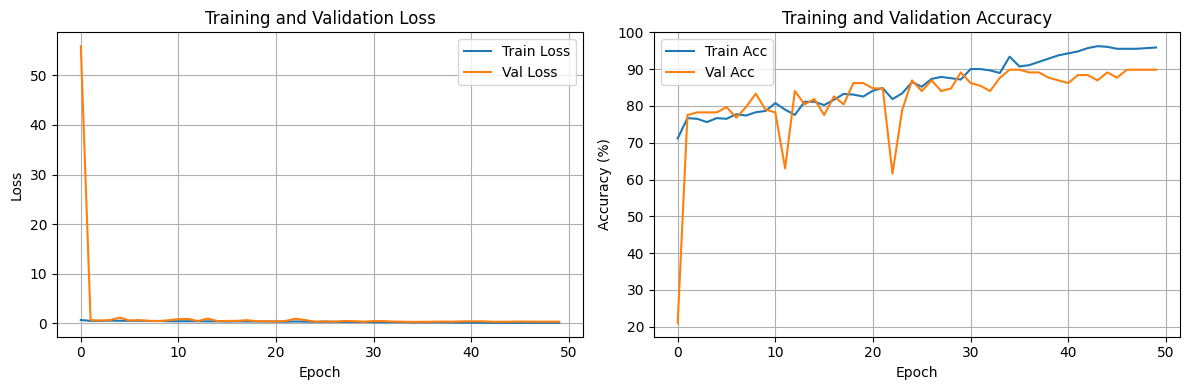

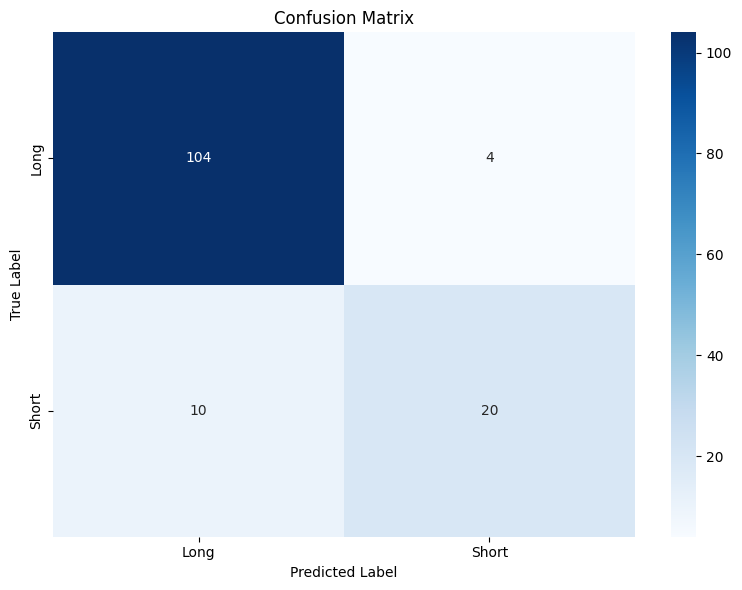

In [8]:
"""
果蝇翅膀分类训练脚本
使用ResNet进行长翅/短翅分类
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


class FlyClassificationDataset(Dataset):
    """果蝇分类数据集"""
    def __init__(self, data_root, split='train', transform=None, exclude_ambiguous=True):
        """
        Args:
            data_root: 数据根目录
            split: 'train' 或 'val'
            transform: 数据转换
            exclude_ambiguous: 是否排除Ambiguous类别
        """
        self.data_root = Path(data_root) / split
        self.transform = transform

        # 类别映射
        if exclude_ambiguous:
            self.class_to_idx = {'Long': 0, 'Short': 1}
            self.classes = ['Long', 'Short']
        else:
            self.class_to_idx = {'Ambiguous': 0, 'Long': 1, 'Short': 2}
            self.classes = ['Ambiguous', 'Long', 'Short']

        # 加载图像路径
        self.samples = []
        for class_name in self.classes:
            class_dir = self.data_root / class_name
            if not class_dir.exists():
                continue
            for img_path in class_dir.glob('*.jpg'):
                self.samples.append((str(img_path), self.class_to_idx[class_name]))

        print(f"{split}集: {len(self.samples)} 个样本")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


class FlyClassifier:
    def __init__(self, num_classes=2, model_name='resnet50', pretrained=True):
        """
        Args:
            num_classes: 类别数量
            model_name: 模型名称 ('resnet18', 'resnet50', 'efficientnet_b0', etc.)
            pretrained: 是否使用预训练权重
        """
        self.num_classes = num_classes
        self.model_name = model_name
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # 创建模型
        self.model = self._create_model(pretrained)
        self.model = self.model.to(self.device)

        print(f"模型: {model_name}, 设备: {self.device}, 类别数: {num_classes}")

    def _create_model(self, pretrained):
        """创建模型"""
        if self.model_name == 'resnet18':
            model = models.resnet18(pretrained=pretrained)
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        elif self.model_name == 'resnet50':
            model = models.resnet50(pretrained=pretrained)
            model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        elif self.model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(pretrained=pretrained)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, self.num_classes)
        elif self.model_name == 'mobilenet_v2':
            model = models.mobilenet_v2(pretrained=pretrained)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, self.num_classes)
        else:
            raise ValueError(f"不支持的模型: {self.model_name}")

        return model

    def train(self, train_loader, val_loader, epochs=50, lr=0.001, save_dir='runs/classification'):
        """训练模型"""
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # 损失函数和优化器
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        best_acc = 0.0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        print("\n=== 开始训练 ===")
        for epoch in range(epochs):
            # 训练阶段
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
            for images, labels in pbar:
                images, labels = images.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()

                pbar.set_postfix({'loss': f'{loss.item():.4f}',
                                 'acc': f'{100.*train_correct/train_total:.2f}%'})

            train_loss /= len(train_loader)
            train_acc = 100. * train_correct / train_total

            # 验证阶段
            val_loss, val_acc = self.validate(val_loader, criterion)

            # 更新学习率
            scheduler.step()

            # 记录历史
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")

            # 保存最佳模型
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc,
                    'model_name': self.model_name,
                    'num_classes': self.num_classes,
                }, save_dir / 'best_model.pth')
                print(f"✅ 保存最佳模型 (Val Acc: {val_acc:.2f}%)")

        # 保存训练历史
        with open(save_dir / 'history.json', 'w') as f:
            json.dump(history, f, indent=2)

        # 绘制训练曲线
        self.plot_history(history, save_dir)

        print(f"\n✅ 训练完成！最佳验证准确率: {best_acc:.2f}%")
        print(f"模型保存在: {save_dir / 'best_model.pth'}")

        return history

    def validate(self, val_loader, criterion=None):
        """验证模型"""
        self.model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        if criterion is None:
            criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total

        return val_loss, val_acc

    def evaluate(self, test_loader, class_names, save_dir='runs/classification'):
        """详细评估模型"""
        self.model.eval()
        all_preds = []
        all_labels = []

        print("\n=== 评估模型 ===")
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="评估中"):
                images = images.to(self.device)
                outputs = self.model(images)
                _, predicted = outputs.max(1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())

        # 分类报告
        print("\n分类报告:")
        print(classification_report(all_labels, all_preds, target_names=class_names))

        # 混淆矩阵
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()

        save_dir = Path(save_dir)
        plt.savefig(save_dir / 'confusion_matrix.png')
        print(f"\n混淆矩阵保存在: {save_dir / 'confusion_matrix.png'}")

        return all_preds, all_labels

    def plot_history(self, history, save_dir):
        """绘制训练历史"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Loss
        ax1.plot(history['train_loss'], label='Train Loss')
        ax1.plot(history['val_loss'], label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy
        ax2.plot(history['train_acc'], label='Train Acc')
        ax2.plot(history['val_acc'], label='Val Acc')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig(Path(save_dir) / 'training_history.png')
        print(f"训练曲线保存在: {Path(save_dir) / 'training_history.png'}")

    def load_model(self, model_path):
        """加载模型"""
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f"加载模型: {model_path}")
        print(f"最佳准确率: {checkpoint['best_acc']:.2f}%")


def main():
    # 配置参数
    data_root = "datasets/classification"
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    img_size = 224

    # 数据转换
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 创建数据集
    train_dataset = FlyClassificationDataset(data_root, 'train', train_transform, exclude_ambiguous=True)
    val_dataset = FlyClassificationDataset(data_root, 'val', val_transform, exclude_ambiguous=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # 创建分类器
    classifier = FlyClassifier(num_classes=2, model_name='resnet50', pretrained=True)

    # 训练
    history = classifier.train(train_loader, val_loader, epochs=num_epochs, lr=learning_rate)

    # 评估
    classifier.evaluate(val_loader, class_names=['Long', 'Short'])


if __name__ == "__main__":
    main()


## Inference

In [ ]:
"""
端到端推理脚本
完整的检测+分类流程
"""

import torch
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
from ultralytics import YOLO
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class FlyDetectionClassificationPipeline:
    """果蝇检测和分类端到端流程"""

    def __init__(self, detection_model_path, classification_model_path,
                 classification_model_name='resnet50', num_classes=2, conf_threshold=0.25):
        """
        Args:
            detection_model_path: 检测模型路径
            classification_model_path: 分类模型路径
            classification_model_name: 分类模型名称
            num_classes: 分类类别数
            conf_threshold: 检测置信度阈值
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.conf_threshold = conf_threshold

        # 加载检测模型
        print("加载检测模型...")
        self.detection_model = YOLO(detection_model_path)

        # 加载分类模型
        print("加载分类模型...")
        self.classification_model = self._load_classification_model(
            classification_model_path, classification_model_name, num_classes
        )

        # 分类类别
        self.class_names = ['Long', 'Short']

        # 分类图像转换
        self.classification_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        print(f"✅ 模型加载完成！设备: {self.device}")

    def _load_classification_model(self, model_path, model_name, num_classes):
        """加载分类模型"""
        # 创建模型架构
        if model_name == 'resnet18':
            model = models.resnet18()
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_name == 'resnet50':
            model = models.resnet50()
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_name == 'efficientnet_b0':
            model = models.efficientnet_b0()
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        elif model_name == 'mobilenet_v2':
            model = models.mobilenet_v2()
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        else:
            raise ValueError(f"不支持的模型: {model_name}")

        # 加载权重
        checkpoint = torch.load(model_path, map_location=self.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(self.device)
        model.eval()

        return model

    def detect_flies(self, image):
        """检测图像中的果蝇

        Args:
            image: PIL Image 或 numpy array

        Returns:
            boxes: 检测框 [[x1, y1, x2, y2, conf], ...]
        """
        results = self.detection_model(image, conf=self.conf_threshold, verbose=False)

        boxes = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                boxes.append([x1, y1, x2, y2, conf])

        return np.array(boxes) if boxes else np.array([]).reshape(0, 5)

    def classify_fly(self, image, box):
        """对检测到的果蝇进行分类

        Args:
            image: PIL Image
            box: [x1, y1, x2, y2, conf]

        Returns:
            class_name: 类别名称
            confidence: 分类置信度
        """
        x1, y1, x2, y2 = map(int, box[:4])

        # 裁剪果蝇区域
        cropped = image.crop((x1, y1, x2, y2))

        # 转换图像
        img_tensor = self.classification_transform(cropped).unsqueeze(0).to(self.device)

        # 分类
        with torch.no_grad():
            outputs = self.classification_model(img_tensor)
            probs = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probs, 1)

        class_name = self.class_names[predicted.item()]
        confidence = confidence.item()

        return class_name, confidence

    def process_image(self, image_path, save_path=None, save_crops=False, crops_dir=None):
        """处理单张图像

        Args:
            image_path: 图像路径
            save_path: 结果保存路径
            save_crops: 是否保存裁剪的果蝇图像
            crops_dir: 裁剪图像保存目录

        Returns:
            results: [{'box': [x1, y1, x2, y2], 'det_conf': conf,
                      'class': class_name, 'cls_conf': conf}, ...]
        """
        # 读取图像
        image = Image.open(image_path).convert('RGB')

        # 检测果蝇
        boxes = self.detect_flies(image)

        results = []
        for i, box in enumerate(boxes):
            # 分类
            class_name, cls_conf = self.classify_fly(image, box)

            result = {
                'box': box[:4].tolist(),
                'det_conf': float(box[4]),
                'class': class_name,
                'cls_conf': float(cls_conf)
            }
            results.append(result)

            # 保存裁剪图像
            if save_crops and crops_dir:
                x1, y1, x2, y2 = map(int, box[:4])
                cropped = image.crop((x1, y1, x2, y2))
                crop_path = Path(crops_dir) / class_name / f"{Path(image_path).stem}_{i}.jpg"
                crop_path.parent.mkdir(parents=True, exist_ok=True)
                cropped.save(crop_path)

        # 可视化并保存
        if save_path:
            self.visualize_results(image_path, results, save_path)

        return results

    def process_batch(self, image_dir, output_dir, save_crops=False):
        """批量处理图像

        Args:
            image_dir: 图像目录
            output_dir: 输出目录
            save_crops: 是否保存裁剪图像
        """
        image_dir = Path(image_dir)
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

        vis_dir = output_dir / 'visualizations'
        vis_dir.mkdir(exist_ok=True)

        crops_dir = output_dir / 'crops' if save_crops else None
        if crops_dir:
            for class_name in self.class_names:
                (crops_dir / class_name).mkdir(parents=True, exist_ok=True)

        # 获取所有图像
        image_paths = list(image_dir.glob('*.jpg')) + list(image_dir.glob('*.png'))

        all_results = {}
        stats = {'Long': 0, 'Short': 0}

        print(f"\n处理 {len(image_paths)} 张图像...")
        for img_path in tqdm(image_paths):
            save_path = vis_dir / img_path.name
            results = self.process_image(img_path, save_path, save_crops, crops_dir)

            all_results[img_path.name] = results

            # 统计
            for result in results:
                stats[result['class']] += 1

        # 保存结果
        with open(output_dir / 'results.json', 'w', encoding='utf-8') as f:
            json.dump(all_results, f, indent=2, ensure_ascii=False)

        # 打印统计信息
        print(f"\n✅ 处理完成！")
        print(f"结果保存在: {output_dir}")
        print(f"\n统计信息:")
        total = sum(stats.values())
        for class_name, count in stats.items():
            percentage = 100 * count / total if total > 0 else 0
            print(f"  {class_name}: {count} ({percentage:.1f}%)")

        # 保存统计
        with open(output_dir / 'statistics.json', 'w', encoding='utf-8') as f:
            json.dump(stats, f, indent=2, ensure_ascii=False)

        return all_results, stats

    def visualize_results(self, image_path, results, save_path):
        """可视化检测和分类结果"""
        # 读取图像
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 绘制
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(image)

        colors = {'Long': 'green', 'Short': 'red'}

        for result in results:
            x1, y1, x2, y2 = result['box']
            class_name = result['class']
            det_conf = result['det_conf']
            cls_conf = result['cls_conf']

            color = colors.get(class_name, 'blue')

            # 绘制检测框
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # 添加标签
            label = f"{class_name} {cls_conf:.2f}"
            ax.text(x1, y1-10, label, color='white', fontsize=10,
                   bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=2))

        ax.axis('off')
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()


def main():
    # 配置路径
    detection_model_path = "runs/detect/fly_detector/weights/best.pt"
    classification_model_path = "runs/classification/best_model.pth"

    # 创建推理流程
    pipeline = FlyDetectionClassificationPipeline(
        detection_model_path=detection_model_path,
        classification_model_path=classification_model_path,
        classification_model_name='resnet50',
        num_classes=2,
        conf_threshold=0.25
    )

    # 选择处理模式
    import sys
    if len(sys.argv) > 1:
        mode = sys.argv[1]
    else:
        mode = 'batch'  # 默认批量处理

    if mode == 'single':
        # 单张图像测试
        if len(sys.argv) > 2:
            image_path = sys.argv[2]
        else:
            image_path = "data/flys/MVIMG_20251202_153157.jpg"

        output_path = "test_output.jpg"
        results = pipeline.process_image(image_path, save_path=output_path,
                                        save_crops=True, crops_dir='test_crops')

        print(f"\n检测到 {len(results)} 只果蝇:")
        for i, result in enumerate(results, 1):
            print(f"  {i}. {result['class']} (分类置信度: {result['cls_conf']:.3f}, "
                  f"检测置信度: {result['det_conf']:.3f})")

    else:
        # 批量处理
        if len(sys.argv) > 2:
            image_dir = sys.argv[2]
        else:
            image_dir = "processed_data/detection/val/images"

        output_dir = "inference_results"

        all_results, stats = pipeline.process_batch(
            image_dir=image_dir,
            output_dir=output_dir,
            save_crops=True
        )


if __name__ == "__main__":
    main()
